# 🏠 Housing Prices 🏠
## 4. Feature Importance and Hyperparameter Tuning

In [11]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Image, display_svg, SVG
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import dtreeviz
import optuna

pd.options.display.max_rows = 40
pd.options.display.max_columns = 40


In [2]:
df = pd.read_csv('../input/home-data-for-ml-course/train.csv')
dft = pd.read_csv('../input/home-data-for-ml-course/test.csv')

columns = df.columns.tolist()

nan_row = {col: np.nan for col in columns}

# Convert to DataFrame
df_nan = pd.DataFrame([nan_row])

df = pd.concat([df,df_nan]).reset_index(drop=True)
df = df.drop(columns=['Id'])
df.loc[df.YrSold.isna(),'YrSold'] = 2008.

dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

cond = (df.YrSold<2010)

train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [3]:
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
to.items = to.items.drop(index=1460)

/home/ian/micromamba/envs/dataphilly/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/home/ian/micromamba/envs/dataphilly/lib/python3.12/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [4]:
xs, y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs,to.valid.y

In [5]:
def r_mse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y):
    return r_mse(m.predict(xs), y)

## Create a Random Forest Model

In [6]:
model = RandomForestRegressor()
model.fit(xs, y)
m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y), r2_score(valid_y, model.predict(valid_xs))

(0.054117, 0.127566, 0.9016475768647769)

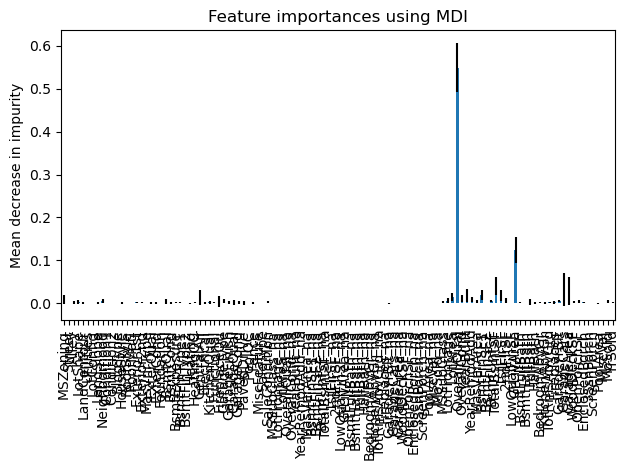

In [7]:
importances = model.feature_importances_
feature_names = xs.columns
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [8]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, valid_xs, valid_y, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)


Elapsed time to compute the importances: 7.508 seconds


In [9]:
sorted_importances = forest_importances.sort_values(ascending=False)
importances_std = pd.Series(result.importances_std, index=feature_names)
sorted_importances_std = importances_std[sorted_importances.index]

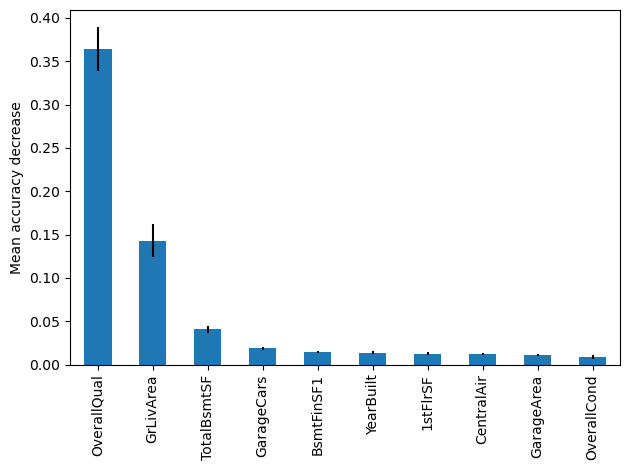

In [10]:
fig, ax = plt.subplots()
keep = 10
sorted_importances[:keep].plot.bar(yerr=sorted_importances_std[:keep], ax=ax)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [23]:
# Hyperparameter optimization of RandomForestRegressor

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 1, 200)
    # max_depth = trial.suggest_int("max_depth", 3, 30)
    # min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    # min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    # max_features = trial.suggest_categorical("max_features", [1])

    # Create and evaluate the model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        # max_depth=max_depth,
        # min_samples_split=min_samples_split,
        # min_samples_leaf=min_samples_leaf,
        # max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
    model.fit(xs, y)
    score = m_rmse(model, valid_xs, valid_y)
    # return np.mean(score)  # Optuna minimizes, so negative MSE
    return score

# Run the optimization
# sampler=optuna.samplers.GPSampler()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters found:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(xs, y)

# Evaluate on test set
test_score = final_model.score(valid_xs, valid_y)
rmse_result = m_rmse(final_model, valid_xs, valid_y)
print("Test RMSE Score:", rmse_result)
print("Test R^2 Score:", test_score)


[I 2025-03-06 10:48:59,549] A new study created in memory with name: no-name-e2fb027b-e598-43df-b084-35b343372d88
[I 2025-03-06 10:48:59,945] Trial 0 finished with value: 0.126098 and parameters: {'n_estimators': 140}. Best is trial 0 with value: 0.126098.
[I 2025-03-06 10:49:00,154] Trial 1 finished with value: 0.125746 and parameters: {'n_estimators': 67}. Best is trial 1 with value: 0.125746.
[I 2025-03-06 10:49:00,451] Trial 2 finished with value: 0.126354 and parameters: {'n_estimators': 99}. Best is trial 1 with value: 0.125746.
[I 2025-03-06 10:49:00,718] Trial 3 finished with value: 0.125688 and parameters: {'n_estimators': 89}. Best is trial 3 with value: 0.125688.
[I 2025-03-06 10:49:01,009] Trial 4 finished with value: 0.126517 and parameters: {'n_estimators': 97}. Best is trial 3 with value: 0.125688.
[I 2025-03-06 10:49:01,156] Trial 5 finished with value: 0.125638 and parameters: {'n_estimators': 45}. Best is trial 5 with value: 0.125638.
[I 2025-03-06 10:49:01,726] Trial

Best parameters found: {'n_estimators': 44}
Test RMSE Score: 0.124925
Test R^2 Score: 0.905677587286687


In [26]:
# Hyperparameter optimization of RandomForestRegressor

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 1, 200)
    # max_depth = trial.suggest_int("max_depth", 3, 30)
    # min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    # min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    # max_features = trial.suggest_categorical("max_features", [1])

    # Create and evaluate the model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        # max_depth=max_depth,
        # min_samples_split=min_samples_split,
        # min_samples_leaf=min_samples_leaf,
        # max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
    model.fit(xs, y)
    score = m_rmse(model, valid_xs, valid_y)
    # return np.mean(score)  # Optuna minimizes, so negative MSE
    return score

# Run the optimization
# sampler=optuna.samplers.GPSampler()
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters found:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(xs, y)

# Evaluate on test set
test_score = final_model.score(valid_xs, valid_y)
rmse_result = m_rmse(final_model, valid_xs, valid_y)
print("Test RMSE Score:", rmse_result)
print("Test R^2 Score:", test_score)


[I 2025-03-06 10:52:57,015] A new study created in memory with name: no-name-e456557a-351d-475c-badb-764c13267018
[I 2025-03-06 10:52:57,552] Trial 0 finished with value: 0.126124 and parameters: {'n_estimators': 188}. Best is trial 0 with value: 0.126124.
[I 2025-03-06 10:52:57,689] Trial 1 finished with value: 0.124417 and parameters: {'n_estimators': 43}. Best is trial 1 with value: 0.124417.
[I 2025-03-06 10:52:58,018] Trial 2 finished with value: 0.126438 and parameters: {'n_estimators': 113}. Best is trial 1 with value: 0.124417.
[I 2025-03-06 10:52:58,403] Trial 3 finished with value: 0.126458 and parameters: {'n_estimators': 112}. Best is trial 1 with value: 0.124417.
[I 2025-03-06 10:52:58,883] Trial 4 finished with value: 0.1261 and parameters: {'n_estimators': 142}. Best is trial 1 with value: 0.124417.
[I 2025-03-06 10:52:58,945] Trial 5 finished with value: 0.135096 and parameters: {'n_estimators': 10}. Best is trial 1 with value: 0.124417.
[I 2025-03-06 10:52:59,106] Tria

Best parameters found: {'n_estimators': 43}
Test RMSE Score: 0.124417
Test R^2 Score: 0.9064430858512975


In [39]:
# Hyperparameter optimization of RandomForestRegressor

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 30, 55)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    # min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    # min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    # max_features = trial.suggest_categorical("max_features", [1])

    # Create and evaluate the model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        # min_samples_split=min_samples_split,
        # min_samples_leaf=min_samples_leaf,
        # max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    # score = cross_val_score(model, xs, y, cv=5, scoring=m_rmse)
    model.fit(xs, y)
    score = m_rmse(model, valid_xs, valid_y)
    # return np.mean(score)  # Optuna minimizes, so negative MSE
    return score

# Run the optimization
study = optuna.create_study(sampler=optuna.samplers.GPSampler(), direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=1)

# Print best parameters
print("Best parameters found:", study.best_params)

# Train final model with best parameters
best_params = study.best_params
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(xs, y)

# Evaluate on test set
test_score = final_model.score(valid_xs, valid_y)
rmse_result = m_rmse(final_model, valid_xs, valid_y)
print("Test RMSE Score:", rmse_result)
print("Test R^2 Score:", test_score)


/tmp/ipykernel_1794989/1103026323.py:31: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
[I 2025-03-06 10:59:18,444] A new study created in memory with name: no-name-7cf5de85-c206-4be7-9575-8e6cbd20fd4e
[I 2025-03-06 10:59:18,548] Trial 0 finished with value: 0.129195 and parameters: {'n_estimators': 37, 'max_depth': 9}. Best is trial 0 with value: 0.129195.
[I 2025-03-06 10:59:18,656] Trial 1 finished with value: 0.12821 and parameters: {'n_estimators': 47, 'max_depth': 8}. Best is trial 1 with value: 0.12821.
[I 2025-03-06 10:59:18,721] Trial 2 finished with value: 0.165224 and parameters: {'n_estimators': 39, 'max_depth': 4}. Best is trial 1 with value: 0.12821.
[I 2025-03-06 10:59:18,861] Trial 3 finished with value: 0.127019 and parameters: {'n_estimators': 45, 'max_depth': 14}. Best is trial 3 with value: 0.127019.
[I 2025-03-06 10:59:18,935] Trial 4 finished with value: 0.127865 and parameters: {'n_estimators': 30, 

Best parameters found: {'n_estimators': 33, 'max_depth': 16}
Test RMSE Score: 0.12396
Test R^2 Score: 0.9071298154645029
